# California Housing Regression MLP using Wide and Deep NN

We will use Scikit-Learn’s fetch_california_housing to get the dataset. This is a simple dataset with no missing values

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)


In [4]:
X_train_full

array([[   4.2143    ,   37.        ,    5.28823529, ...,    2.52941176,
          33.81      , -118.12      ],
       [   5.3468    ,   42.        ,    6.36432161, ...,    2.40452261,
          37.16      , -121.98      ],
       [   3.9191    ,   36.        ,    6.11006289, ...,    2.23584906,
          38.45      , -122.69      ],
       ...,
       [   2.9344    ,   36.        ,    3.98671727, ...,    3.33206831,
          34.03      , -118.38      ],
       [   5.7192    ,   15.        ,    6.39534884, ...,    3.17889088,
          37.58      , -121.96      ],
       [   2.5755    ,   52.        ,    3.40257649, ...,    2.10869565,
          37.77      , -122.42      ]])

Regression tasks need a scaled parameters

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

## Model Creation

In case of regression, the output layer has a single neuron (since we only want to
predict a single value) and uses no activation function. The loss function is the
mean squared error. Since the dataset is quite noisy, we just use a single hidden layer
with fewer neurons than before, to avoid overfitting.

## Functional API

The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build graphs of layers.

## Wide and Deep Neural Network

It connects all or part of the inputs directly to the output layer This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path). In contrast, a regular MLP forces all the data to flow through the full stack of layers, thus simple patterns in the data may end up being distorted by this sequence of transformations.

In [14]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 30)           270         ['input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 30)           930         ['dense_3[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 38)           0           ['input_2[0][0]',                
                                                                  'dense_4[0][0]']          

## Model Compiling

In [16]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3))

## Model Training

In [17]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
363/363 [==============================] - 3s 8ms/step - loss: 1.2611 - val_loss: 3.3940
Epoch 2/20
363/363 [==============================] - 3s 8ms/step - loss: 0.6580 - val_loss: 0.9360
Epoch 3/20
363/363 [==============================] - 2s 7ms/step - loss: 0.5878 - val_loss: 0.5649
Epoch 4/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5582 - val_loss: 0.5712
Epoch 5/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5347 - val_loss: 0.5045
Epoch 6/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5158 - val_loss: 0.4831
Epoch 7/20
363/363 [==============================] - 1s 4ms/step - loss: 0.5002 - val_loss: 0.4639
Epoch 8/20
363/363 [==============================] - 2s 6ms/step - loss: 0.4876 - val_loss: 0.4638
Epoch 9/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4760 - val_loss: 0.4421
Epoch 10/20
363/363 [==============================] - 2s 7ms/step - loss: 0.4659 - val_loss: 0.4313

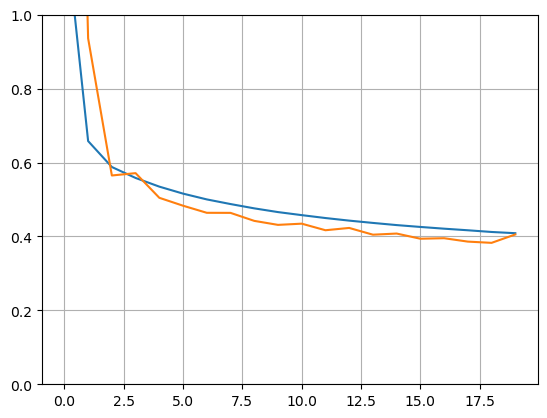

In [18]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Evaluation and Testing

In [19]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3] # pretend these are new instances
y_pred = model.predict(X_new)

162/162 [==============================] - 1s 5ms/step - loss: 0.4032


In [20]:
y_pred

array([[0.47011757],
       [1.873529  ],
       [3.3798187 ]], dtype=float32)

In [21]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

As you can see the model prediction is not near to the actuals. This means a lot of tuning is needed

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

In [22]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [23]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

# Since we passed 2 datasets to compile, we need to pass 2 for fit() also
history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 [==============================] - 3s 8ms/step - loss: 1.7643 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 3s 7ms/step - loss: 0.7584 - val_loss: 0.6710
Epoch 3/20
363/363 [==============================] - 2s 7ms/step - loss: 0.6584 - val_loss: 0.6169
Epoch 4/20
363/363 [==============================] - 2s 5ms/step - loss: 0.6023 - val_loss: 0.5710
Epoch 5/20
363/363 [==============================] - 3s 7ms/step - loss: 0.5663 - val_loss: 0.5420
Epoch 6/20
363/363 [==============================] - 3s 8ms/step - loss: 0.5380 - val_loss: 0.5176
Epoch 7/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5187 - val_loss: 0.5065
Epoch 8/20
363/363 [==============================] - 2s 6ms/step - loss: 0.5025 - val_loss: 0.4790
Epoch 9/20
363/363 [==============================] - 2s 7ms/step - loss: 0.4889 - val_loss: 0.4564
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4781 - val_loss: 0.4451

In [25]:
y_pred[:3],y_test[:3]

(array([[0.32774827],
        [1.9024162 ],
        [3.4076526 ]], dtype=float32),
 array([0.477  , 0.458  , 5.00001]))

## Adding an auxiliary output

An additional output can be needed for different reasons

For ex, there may be actually two outputs, like classification of an image and its location
There may be multiple independent tasks to perform based the same inputs.
For regularisation


In [26]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [29]:
# since we are doing this for regularisation we will pass a higher weight for the main output
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [30]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 [==============================] - 4s 9ms/step - loss: 0.4677 - main_output_loss: 0.4260 - aux_output_loss: 0.8433 - val_loss: 0.4457 - val_main_output_loss: 0.3960 - val_aux_output_loss: 0.8923
Epoch 2/20
363/363 [==============================] - 3s 8ms/step - loss: 0.4646 - main_output_loss: 0.4243 - aux_output_loss: 0.8274 - val_loss: 0.4473 - val_main_output_loss: 0.3995 - val_aux_output_loss: 0.8767
Epoch 3/20
363/363 [==============================] - 2s 7ms/step - loss: 0.4616 - main_output_loss: 0.4226 - aux_output_loss: 0.8122 - val_loss: 0.4419 - val_main_output_loss: 0.3950 - val_aux_output_loss: 0.8636
Epoch 4/20
363/363 [==============================] - 2s 7ms/step - loss: 0.4589 - main_output_loss: 0.4211 - aux_output_loss: 0.7985 - val_loss: 0.4398 - val_main_output_loss: 0.3947 - val_aux_output_loss: 0.8465
Epoch 5/20
363/363 [==============================] - 3s 7ms/step - loss: 0.4564 - main_output_loss: 0.4199 - aux_output_loss: 0.7845 - val_loss

When we evaluate the model, Keras will return the total loss, as well as all the individ‐
ual losses:

In [31]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 1s 6ms/step - loss: 0.4240 - main_output_loss: 0.4015 - aux_output_loss: 0.6268


In [32]:
print(total_loss, main_loss, aux_loss)

0.4240031838417053 0.40146806836128235 0.6268199682235718


Both the Sequential API and the Functional API are declarative: you start by declar‐
ing which layers you want to use and how they should be connected, and only then
can you start feeding the model some data for training or inference. This has many
advantages: the model can easily be saved, cloned, shared, its structure can be dis‐
played and analyzed, the framework can infer shapes and check types, so errors can
be caught early (i.e., before any data ever goes through the model). It’s also fairly easy
to debug, since the whole model is just a static graph of layers. But the flip side is just
that: it’s static. Some models involve loops, varying shapes, conditional branching,
and other dynamic behaviors. For such cases we can use Subclassing API

## Building Dynamic Models Using the Subclassing API

Simply subclass the Model class, create the layers you need in the constructor, and use
them to perform the computations you want in the call() method.

You can do pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations, your imagination is the limit. This makes it a great API for researchers experimenting with new ideas.

However, this extra flexibility comes at a cost: your model’s architecture is hidden
within the call() method, so Keras cannot easily inspect it, it cannot save or clone it,
and when you call the summary() method, you only get a list of layers, without any
information on how they are connected to each other. Moreover, Keras cannot check
types and shapes ahead of time, and it is easier to make mistakes. So unless you really
need that extra flexibility, you should probably stick to the Sequential API or the
Functional API.

In [35]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation = activation)
        self.hidden2 = keras.layers.Dense(units, activation = activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output
    
model = WideAndDeepModel()

In [36]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 [==============================] - 4s 9ms/step - loss: 2.6811 - output_1_loss: 2.3824 - output_2_loss: 5.3690 - val_loss: 4.0827 - val_output_1_loss: 3.6804 - val_output_2_loss: 7.7037
Epoch 2/10
363/363 [==============================] - 3s 8ms/step - loss: 1.0888 - output_1_loss: 0.7882 - output_2_loss: 3.7939 - val_loss: 1.8117 - val_output_1_loss: 0.9127 - val_output_2_loss: 9.9026
Epoch 3/10
363/363 [==============================] - 2s 7ms/step - loss: 0.8406 - output_1_loss: 0.6446 - output_2_loss: 2.6052 - val_loss: 1.6652 - val_output_1_loss: 0.6103 - val_output_2_loss: 11.1593
Epoch 4/10
363/363 [==============================] - 2s 6ms/step - loss: 0.7409 - output_1_loss: 0.5967 - output_2_loss: 2.0386 - val_loss: 1.6267 - val_output_1_loss: 0.5937 - val_output_2_loss: 10.9233
Epoch 5/10
363/363 [==============================] - 4s 12ms/step - loss: 0.6847 - output_1_loss: 0.5645 - output_2_loss: 1.7665 - val_loss: 1.4905 - val_output_1_loss: 0.5594 - val

In [37]:
y_pred_main[:3], y_pred_aux[:3]

(array([[0.37175584],
        [1.6912113 ],
        [2.7433438 ]], dtype=float32),
 array([[1.2221942],
        [1.3960966],
        [2.066905 ]], dtype=float32))